In [1]:
import pandas as pd
import numpy as np

import sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import LinearSVC

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve
import matplotlib.pyplot as plt

In [2]:
all_data = pd.read_csv("../output_files/physics_pairs_data.csv")
pred_tfidf_val = pd.read_csv("data/predicted_prereq.csv")
rank_val = pd.read_csv("data/concept_rank.csv")

In [3]:
all_data["tfidf"] = pred_tfidf_val["tfidf_score"].to_numpy().ravel()

In [4]:
concept_rank = {}

for i in range(rank_val.shape[0]):
    concept = rank_val[["concept"]].iloc[i].values[0]
    rank = rank_val[["rank"]].iloc[i].values[0]
    concept_rank[concept] = rank

In [5]:
def rank_score(c1, c2):
    r1 = int(concept_rank[c1])
    r2 = int(concept_rank[c2])
    return (r1-r2)

In [6]:
pred_rank = []
for i in range(all_data.shape[0]):
    topic_a = all_data[["topic_a"]].iloc[i].values[0]
    topic_b = all_data[["topic_b"]].iloc[i].values[0]
    rank = rank_score(topic_a, topic_b)
    pred_rank.append(rank)

In [7]:
all_data["rank"] = pred_rank

In [8]:
all_data

,Unnamed: 0,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f33,f34,f35,f36,f37,relation,topic_a,topic_b,tfidf,rank
0,0,321.0,190.0,1613.0,197.0,2.0,4.0,19.0,0.0,0.0,...,504.0,87.0,0.000040,0.000086,1.118241e-05,0.0,Magnetic field,Inertial frame of reference,0.081134,39
1,1,36.0,77.0,109.0,101.0,3.0,2.0,4.0,0.0,0.0,...,161.0,21.0,0.000002,0.000002,9.914547e-08,1.0,Gravitational acceleration,Position (vector),0.131200,9
2,2,808.0,495.0,3104.0,2394.0,2.0,3.0,25.0,0.0,0.0,...,1060.0,103.0,-0.000003,-0.000017,1.509753e-05,0.0,Energy,Planet,0.091278,4
3,3,99.0,48.0,96.0,212.0,2.0,4.0,5.0,0.0,0.0,...,128.0,19.0,0.000007,-0.000004,-1.144610e-05,0.0,Mechanical energy,Gravitational field,0.030924,4
4,4,643.0,162.0,9935.0,129.0,1.0,5.0,21.0,0.0,0.0,...,109.0,12.0,0.000095,0.000940,6.710326e-05,0.0,Physics,Electric potential energy,0.000000,-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1957,1957,350.0,203.0,4432.0,92.0,3.0,4.0,22.0,0.0,0.0,...,1078.0,139.0,0.000010,0.000172,2.182559e-05,0.0,Mass,Le Sage's theory of gravitation,0.085340,2
1958,1958,321.0,59.0,1613.0,420.0,2.0,3.0,7.0,1.0,0.0,...,104.0,30.0,0.000113,0.000062,7.647945e-06,0.0,Magnetic field,Length,0.072478,44
1959,1959,127.0,48.0,1368.0,269.0,4.0,1.0,11.0,0.0,0.0,...,269.0,28.0,0.000062,0.000055,8.195897e-06,0.0,Voltage,Series and parallel circuits,0.164116,1
1960,1960,643.0,147.0,9935.0,851.0,1.0,4.0,24.0,0.0,0.0,...,224.0,37.0,0.000150,0.000904,5.851008e-05,0.0,Physics,Velocity,0.000000,-9


# Data Normalization

In [9]:
df = all_data[["relation", "tfidf", "rank", "f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9",
            "f10", "f11", "f12", "f13", "f14", "f15", "f16", "f17", "f18", "f19",
            "f20", "f21", "f22", "f23", "f24", "f25", "f26", "f27", "f28", "f29",
            "f30", "f31", "f32", "f33", "f34", "f35", "f36", "f37"]]

In [10]:
df.corr()

,relation,tfidf,rank,f0,f1,f2,f3,f4,f5,f6,...,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37
relation,1.000000,0.496475,0.344755,-0.274663,0.323858,-0.201647,0.273093,-0.003634,-0.105155,0.049004,...,0.291870,-0.135859,0.358678,-0.162340,-0.217845,0.195284,0.013843,-0.138730,-0.271796,-0.407061
tfidf,0.496475,1.000000,0.397116,-0.161933,0.502133,-0.132262,0.578421,0.024798,-0.238830,-0.002116,...,0.141077,-0.084861,0.206469,-0.110516,-0.131358,0.301384,0.019729,-0.226398,-0.434444,-0.625514
rank,0.344755,0.397116,1.000000,-0.290786,0.285436,-0.286270,0.268754,0.055842,-0.031548,-0.050178,...,0.152388,-0.163709,0.165348,-0.195274,-0.181107,0.216142,-0.006309,-0.219379,-0.327497,-0.486416
f0,-0.274663,-0.161933,-0.290786,1.000000,-0.068297,0.540906,-0.078357,0.016583,0.047338,0.163870,...,0.004098,0.212847,-0.182716,0.164810,0.816726,-0.027999,0.400360,0.339464,0.318917,0.548772
f1,0.323858,0.502133,0.285436,-0.068297,1.000000,-0.073316,0.506576,0.072269,-0.032571,0.218096,...,0.207389,0.009823,0.158203,-0.168357,-0.033677,0.814475,0.420446,-0.412019,-0.323748,-0.554653
f2,-0.201647,-0.132262,-0.286270,0.540906,-0.073316,1.000000,-0.063400,-0.050681,0.021698,0.009639,...,-0.060710,0.073187,-0.111598,0.051422,0.348096,-0.052346,0.093705,0.238469,0.660178,0.647199
f3,0.273093,0.578421,0.268754,-0.078357,0.506576,-0.063400,1.000000,0.055981,0.007001,-0.000206,...,0.063773,-0.064093,0.037333,-0.113562,-0.044151,0.316381,0.070732,-0.249888,-0.757114,-0.652273
f4,-0.003634,0.024798,0.055842,0.016583,0.072269,-0.050681,0.055981,1.000000,0.022369,0.062313,...,0.057540,-0.029286,-0.014453,-0.036761,0.179591,0.063716,0.152876,-0.034541,-0.058944,-0.126162
f5,-0.105155,-0.238830,-0.031548,0.047338,-0.032571,0.021698,0.007001,0.022369,1.000000,0.068393,...,-0.007431,0.068858,-0.010075,0.001170,0.045365,0.144542,0.139768,0.004345,-0.016644,0.096153
f6,0.049004,-0.002116,-0.050178,0.163870,0.218096,0.009639,-0.000206,0.062313,0.068393,1.000000,...,0.253080,0.272388,0.102653,0.118482,0.110690,0.180274,0.481654,-0.018539,0.013969,0.003824


In [11]:
columns = ["f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9",
            "f10", "f11", "f12", "f13", "f14", "f15", "f16", "f17", "f18", "f19",
            "f20", "f21", "f22", "f23", "f24", "f25", "f26", "f27", "f28", "f29",
            "f30", "f31", "f32", "f33", "f34", "f35", "f36", "f37"]

def normalize_array(x):
    x = np.array(x)
    min_x = np.min(x)
    max_x = np.max(x)
    x = (x - min_x)/(max_x - min_x)
    return x


def normalized_df(df):
    X = [normalize_array([df[[col]].values[i][0] for i in range(len(df[[col]]))]) for col in columns]
    X = np.array(X)
    return X.T

X_old = all_data[["f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9",
            "f10", "f11", "f12", "f13", "f14", "f15", "f16", "f17", "f18", "f19",
            "f20", "f21", "f22", "f23", "f24", "f25", "f26", "f27", "f28", "f29",
            "f30", "f31", "f32", "f33", "f34", "f35", "f36", "f37"]]
X_old = normalized_df(X_old)

In [13]:
columns = ["f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9",
            "f10", "f11", "f12", "f13", "f14", "f15", "f16", "f17", "f18", "f19",
            "f20", "f21", "f22", "f23", "f24", "f25", "f26", "f27", "f28", "f29",
            "f30", "f31", "f32", "f33", "f34", "f35", "f36", "f37", "tfidf", "rank"]

def normalize_array(x):
    x = np.array(x)
    min_x = np.min(x)
    max_x = np.max(x)
    x = (x - min_x)/(max_x - min_x)
    return x


def normalized_df(df):
    X = [normalize_array([df[[col]].values[i][0] for i in range(len(df[[col]]))]) for col in columns]
    X = np.array(X)
    return X.T

X_new = all_data[["f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9",
            "f10", "f11", "f12", "f13", "f14", "f15", "f16", "f17", "f18", "f19",
            "f20", "f21", "f22", "f23", "f24", "f25", "f26", "f27", "f28", "f29",
            "f30", "f31", "f32", "f33", "f34", "f35", "f36", "f37", "tfidf", "rank"]]
X_new = normalized_df(X_new)

In [14]:
y = all_data[["relation"]].to_numpy().ravel()

In [15]:
X_old.shape, X_new.shape, y.shape

((1962, 38), (1962, 40), (1962,))

# Data Modeling along with our features

In [16]:
def print_results(result):
    print("Precision: %.1f" % result[0])
    print("Recall: %.1f" % result[1])
    print("F1 Score: %.1f" % result[2])
    print("Area Under Curve: %.1f" % result[3])

def evaluation_results(y_test, y_predict):
    recall = recall_score(y_test, y_predict)*100
    precision = precision_score(y_test, y_predict)*100
    f1 = f1_score(y_test, y_predict)*100
    auc = roc_auc_score(y_test, y_predict)*100
    return [precision, recall, f1, auc]


def model_train(x_train, x_test, y_train, y_test, model, sample_weight):
    model.fit(x_train, y_train, sample_weight)
    y_predict = model.predict(x_test)
    return evaluation_results(y_test, y_predict)


def k_fold_training(X, Y, model, sample_weight):
    results = []
    kf = KFold(n_splits = 5)
    kf.get_n_splits(X)
    for train_index, test_index in kf.split(X):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        weight_train = sample_weight[train_index]
        result = model_train(x_train, x_test, y_train, y_test, model, weight_train)
        results.append(result)
    results = np.array(results)
    final_result = np.mean(results, axis = 0)
    return final_result

def model_training(X, Y, model, sample_weight):
    results = []
    for i in range(5):
        result = k_fold_training(X_old, y, model, sample_weight)
        results.append(result)
    results = np.array(results)
    final_result = np.mean(results, axis = 0)
    return final_result

## Random Forest with Old Features

In [17]:
rand_params = {
    "n_estimators" : 200,
    "max_features" : 'auto',
}
model = RandomForestClassifier(**rand_params)
sample_weight = np.ones((len(y)))
result = model_training(X_old, y, model, sample_weight)
print_results(result)

Precision: 82.9
Recall: 62.4
F1 Score: 71.1
Area Under Curve: 79.1


## Random Forest with New Features

In [18]:
rand_params = {
    "n_estimators" : 200,
    "max_features" : 'auto',
}
model = RandomForestClassifier(**rand_params)
sample_weight = np.ones((len(y)))
result = model_training(X_new, y, model, sample_weight)
print_results(result)

Precision: 83.2
Recall: 62.7
F1 Score: 71.4
Area Under Curve: 79.3


## Random Forest with 2 Proposed Features

In [19]:
X_new[:,38:40].shape

(1962, 2)

In [20]:
rand_params = {
    "n_estimators" : 200,
    "max_features" : 'auto',
}
model = RandomForestClassifier(**rand_params)
sample_weight = np.ones((len(y)))
result = model_training(X_new[:,38:40], y, model, sample_weight)
print_results(result)

Precision: 82.9
Recall: 62.7
F1 Score: 71.2
Area Under Curve: 79.2


## Random Forest with Self Learning

In [23]:
tfidf = X_new[:,38]
rank_diff = X_new[:,39]

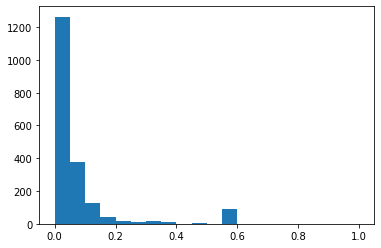

In [24]:
plt.hist(tfidf, bins = 20)
plt.show()

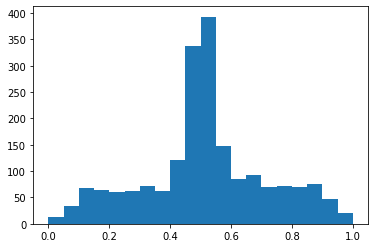

In [25]:
plt.hist(rank_diff, bins = 20)
plt.show()

In [27]:
w = []
for i in range(len(tfidf)):
    if tfidf[i] <= 0.1:
        w.append(0.5)
    elif tfidf[i] > 0.1 and tfidf[i] < 0.5:
        w.append(1.0)
    else:
        w.append(1.5)

w = np.array(w)

In [28]:
rand_params = {
    "n_estimators" : 200,
    "max_features" : 'auto',
}
model = RandomForestClassifier(**rand_params)
sample_weight = w
result = model_training(X_new, y, model, sample_weight)
print_results(result)

Precision: 83.8
Recall: 61.5
F1 Score: 70.8
Area Under Curve: 78.8


In [23]:
model = LinearSVC(random_state=0, tol=1e-5)
sample_weight = np.ones((len(y)))
result = model_training(X_old, y, model, sample_weight)
print_results(result)

print("\n")

model = LinearSVC(random_state=0, tol=1e-5)
sample_weight = np.ones((len(y)))
result = model_training(X_new, y, model, sample_weight)
print_results(result)

print("\n")

model = LinearSVC(random_state=0, tol=1e-5)
sample_weight = np.ones((len(y)))
result = model_training(X_new[:,38:40], y, model, sample_weight)
print_results(result)

# print("\n")

# model_training(X_new[:,38:40], y, model, sample_weight)

Precision: 77.4
Recall: 52.1
F1 Score: 62.2
Area Under Curve: 73.6


Precision: 77.4
Recall: 52.1
F1 Score: 62.2
Area Under Curve: 73.6


Precision: 77.4
Recall: 52.1
F1 Score: 62.2
Area Under Curve: 73.6


In [24]:
model = LogisticRegression(solver='lbfgs')
sample_weight = np.ones((len(y)))
result = model_training(X_old, y, model, sample_weight)
print_results(result)

print("\n")

model = LogisticRegression(solver='lbfgs')
sample_weight = np.ones((len(y)))
result = model_training(X_new, y, model, sample_weight)
print_results(result)

print("\n")

model = LogisticRegression(solver='lbfgs')
sample_weight = np.ones((len(y)))
result = model_training(X_new[:,38:40], y, model, sample_weight)
print_results(result)

# print("\n")

# model_training(X_new[:,38:40], y, model, sample_weight)

Precision: 78.2
Recall: 48.3
F1 Score: 59.6
Area Under Curve: 72.0


Precision: 78.2
Recall: 48.3
F1 Score: 59.6
Area Under Curve: 72.0


Precision: 78.2
Recall: 48.3
F1 Score: 59.6
Area Under Curve: 72.0


## Naive Bayes

In [25]:
model = GaussianNB()
result = k_fold_training(X, y, model)
print_results(result)

NameError: name 'X' is not defined

## Logistic Regression

In [ ]:
model = LogisticRegression(solver='lbfgs')
result = k_fold_training(X, y, model)
print_results(result)

## SVM

In [ ]:
model = LinearSVC(random_state=0, tol=1e-5)
result = k_fold_training(X, y, model)
print_results(result)